In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import networkx as nx
import pymc as pm

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
import networkx as nx
import matplotlib.pyplot as plt

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


In [2]:
# Import r package
pandas2ri.activate()
bnlearn = importr("bnlearn")

## Generate random DAG

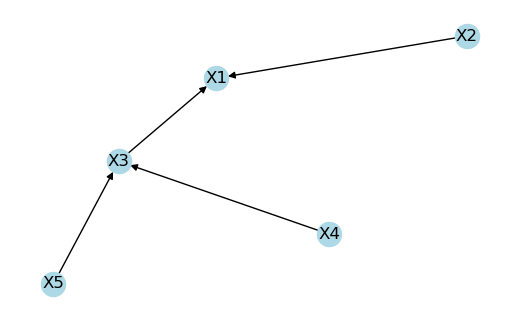

In [3]:
nodes = [f"X{i+1}" for i in range (5)]
p = len(nodes)

plt.figure(figsize = (5, 3))
g_rd = nx.gn_graph(p, seed = 1)
g = nx.DiGraph()
g.add_nodes_from(nodes)

for node_from, node_to in g_rd.edges():
    g.add_edge(nodes[node_from], nodes[node_to])
nx.draw(g, with_labels = True, node_color='lightblue')


## Set parameters

In [4]:
# parameters (mean, std)
random.seed(42)
root_params = {}
nonroot_coefs = {}

for node in nodes:
    parents = [parent for parent in g.predecessors(node)]
    if len(parents) == 0:
        mu = random.uniform(1, 3)
        sig = random.uniform(1, 3)
        root_params[node] = (mu, sig)
    else:
        nonroot_coefs[node] = [random.randint(-5, 5) for _ in range(len(parents))] 

print(root_params)
print(nonroot_coefs)

{'X2': (1.0500215104453339, 1.5500586367382385), 'X4': (2.472942428328025, 2.3533989748458226), 'X5': (2.784359135409691, 1.1738776652588323)}
{'X1': [5, -4], 'X3': [-2, -3]}


## Construct model
- **Root nodes**: Stochastic variables
- **Non-root nodes**: Deterministic variables

In [5]:
tpsort = list(nx.topological_sort(g))
print(tpsort)

with pm.Model() as model:
    particle = {}
    for node in tpsort:
        parents = [parent for parent in g.predecessors(node)]
        
        # Root node
        if len(parents) == 0:
            mu, sig = root_params[node]
            particle[node] = pm.Normal(node, mu = mu, sigma = sig)
        
        # Non-root node
        else:
            pred = 1 + np.random.normal(0, 0.5) # intercept
            coefs = nonroot_coefs[node]
            for i, pa in enumerate(parents):
                pred +=  coefs[i]*particle[pa]
                
            particle[node] = pm.Deterministic(node, pred)    

num_samples = 1000
with model:
    trace = pm.sample(num_samples, tune=500, progressbar=False)     

['X2', 'X4', 'X5', 'X3', 'X1']


## Draw samples from the model

In [6]:
num_samples = 1000
with model:
    trace = pm.sample(num_samples, tune=500, progressbar=False)      
    
samples = {}
for node in nodes:
    samples[node] = trace.posterior[node][0]
df = pd.DataFrame(samples, columns = nodes)
df.head()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [X2, X4, X5]
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 0 seconds.


,X1,X2,X3,X4,X5
0,31.548772,1.249930,-5.840949,3.877434,-0.462502
1,67.355088,0.305166,-15.973483,2.661481,3.725644
2,48.223327,1.369076,-9.860656,1.591282,2.401501
3,51.857630,0.773039,-11.514277,3.423498,1.731231
4,68.815544,2.283477,-13.865708,1.652382,3.695785


## Learn BN from sample data

In [7]:
# Hill climbing algorithm
bn_r = bnlearn.hc(df)
bn_pd = ro.conversion.rpy2py(bn_r)
bn = dict(zip(bn_pd.names, map(list,list(bn_pd))))
edges = bn['arcs']
edges = (np.asmatrix(edges).reshape(2,-1)).T.tolist()
print(f"Number of edges: {len(edges)}")   

Number of edges: 5


## Compare true network and learned network

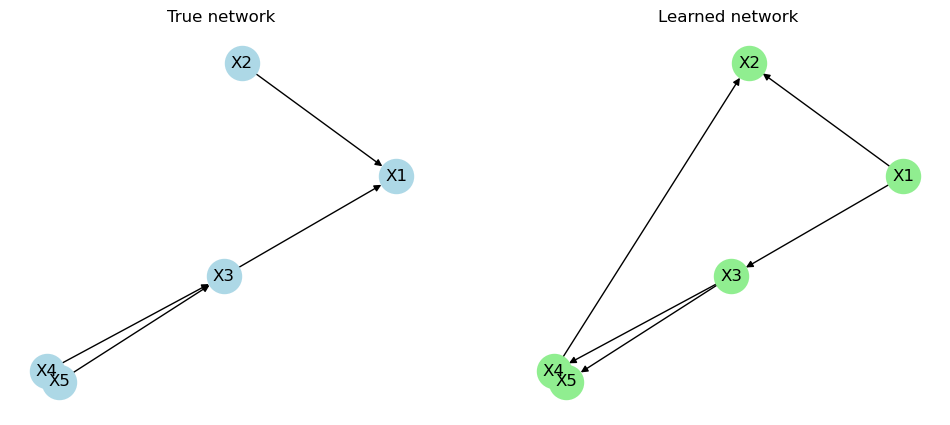

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
pos = nx.kamada_kawai_layout(g)

# true network
nx.draw(g, pos, with_labels = True, node_color='lightblue',node_size = 600, ax = ax[0])

# learned network
g_learned = nx.DiGraph()
g_learned.add_nodes_from(df.columns.values)
g_learned.add_edges_from(edges)

nx.draw(g_learned, pos, with_labels = True, node_color='lightgreen', node_size = 600, ax = ax[1])

ax[0].set_title("True network")
ax[1].set_title("Learned network");